<a href="https://colab.research.google.com/github/mifm/examples/blob/master/Borselle_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Borselle case study in IRR optimization

In [53]:
# Install PyWake if needed
import importlib
if not importlib.util.find_spec("py_wake"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

# Install Topfarm if needed
if not importlib.util.find_spec("topfarm"):
    !pip install topfarm
!pip install openmdao==3.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openmdao: filename=openmdao-3.28.0-py3-none-any.whl size=6192819 sha256=afe6535e19635019ac42de982765334595bf0876a0df3b46488e4e27aac48805
  Stored in directory: /root/.cache/pip/wheels/a1/85/e8/4861569b8d3965486e4108cd2876c987b43bcd1b1a5ad1ea68
Successfully built openmdao
  Attempting uninstall: openmdao
    Found existing installation: openmdao 3.31.1
    Uninstalling openmdao-3.31.1:
      Successfully uninstalled openmdao-3.31.1


In [1]:
import numpy as np
import xarray as xr
from matplotlib import pylab as plt

## Site set-up

First we will set up the site for the analysis including the wind resoure, turbine selection and specifications, site boundaries, and initial guess at turbine locations

### Wind resource method 1: Data provided directly from call

In [2]:
# Borselle III/IV wind resource data
# Weibull scale (A) and shape factors (k) by sector
A = [9.176929, 9.782334, 9.531809, 9.909545, 10.04269, 9.593921,
        9.584007, 10.51499, 11.39895, 11.68746, 11.63732, 10.08803]
k = [2.11, 2.05, 2.35, 2.55, 2.81, 2.74,
        2.63, 2.40, 2.23, 2.28, 2.29, 2.28]
# probability by sector
f = [0.051, 0.043, 0.043, 0.066, 0.089, 0.065,
            0.087, 0.115, 0.12, 0.111, 0.114, 0.096]
# site average turbulence intensity (TI) and shear (alpha)
ti = 0.11
alpha = .1
# reference height for specified data
h_ref = 119

Now set up the site in PyWake as a uniform weibull site

In [3]:
# Import PyWake uniform weibull site and shear helpfer function
from py_wake.site import UniformWeibullSite
from py_wake.site.xrsite import GlobalWindAtlasSite
from py_wake.site.shear import PowerShear

# set up site
site = UniformWeibullSite(f, A, k, ti, shear=PowerShear(h_ref=h_ref, alpha=alpha))

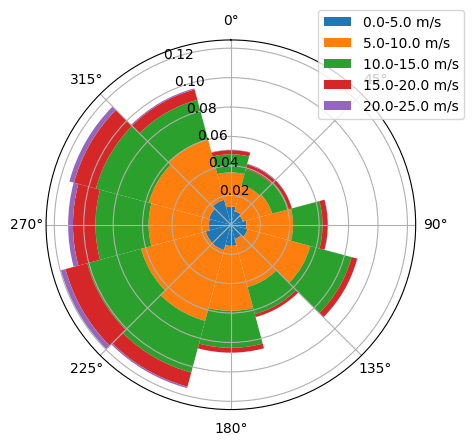

In [4]:
# Plot site weibull to inspect it
site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25]);

### Method 2: Extract data from GlobalWindAtlas

You can use the built in PyWake site that automatically download and load into an xarray.dataset the wind resource given a location latitude and longitude.

In [5]:
lat, long = 51.74, 2.879972

In [6]:
site2 = GlobalWindAtlasSite(lat, long, height=200, roughness=1.5, ti=0.1)

In [7]:
site2.gwc_ds

<xarray.Dataset>
Dimensions:           (roughness: 5, height: 5, wd: 12)
Coordinates:
  * height            (height) float64 10.0 50.0 100.0 150.0 200.0
  * roughness         (roughness) float64 0.0 0.03 0.1 0.4 1.5
  * wd                (wd) float64 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
Data variables:
    Weibull_A         (roughness, height, wd) float64 6.99 6.88 ... 6.99 6.87
    Weibull_k         (roughness, height, wd) float64 1.979 2.061 ... 2.232
    Sector_frequency  (roughness, wd) float64 0.05703 0.06654 ... 0.05859
    TI                float64 0.1

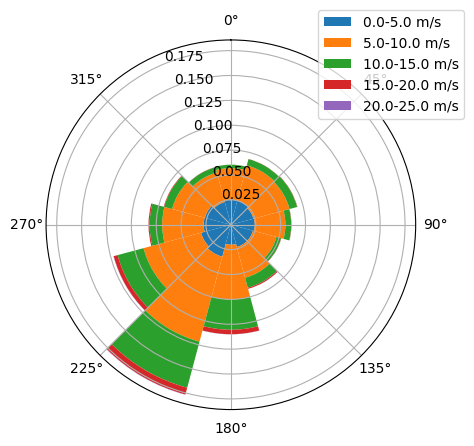

In [8]:
site2.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25]);

Note that the wind rose from the atlas and that from the prescribed data are not the same. We will use the prescribed data for the remainder of the analysis.

<BarContainer object of 23 artists>

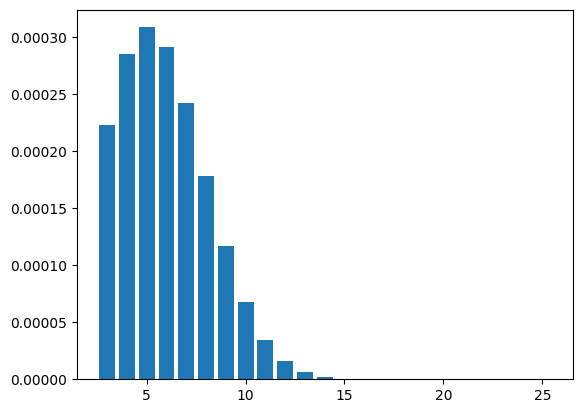

In [9]:
lw = site2.local_wind(0,0)
plt.bar(lw.WS, lw.P[0,:])

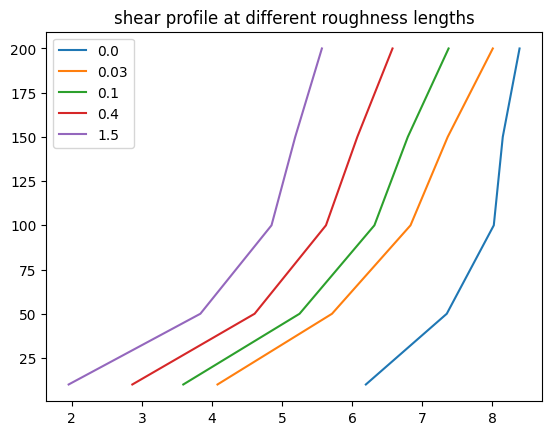

In [10]:
from py_wake.utils.weibull import mean
for roughness in site2.gwc_ds.roughness.values:
    plot_data = site2.gwc_ds.isel(wd=0).interp(roughness=roughness)
    x = mean(plot_data.Weibull_A.values, plot_data.Weibull_k.values)
    y = plot_data.height.values
    plt.plot(x,y, label=roughness)
plt.title('shear profile at different roughness lengths')
plt.legend()

### Set up site boundaries

Finally, we need to set the boundaries for the site

In [11]:
# Site boundaries
site.boundary = np.array([[484178.55, 5732482.8], [500129.9, 5737534.4], [497318.1, 5731880.24], [488951.0, 5.72794e6],
                              [488951.0, 5.72794e6], [497318.1, 5731880.24], [503163.37, 5729155.3], [501266.5, 5715990.05]])

In [12]:
# Plot the site to see what it looks like

## Set up the turbine

Next, we need to set up the turbine for the site

In [13]:
# Set up IEA Wind 10 MW Reference Turbine

# Main turbine specifications
title='IEA Wind 10 MW Offshore Reference Turbine'
rated_power = 10000.
power_unit = 'kW'
diameter = 198.0
hub_height=119.0

# Power curve
power_curve = np.array([[4, 0.0417775416641181 * rated_power],
                        [5, 0.100966625080239 * rated_power],
                        [6, 0.184703860860372 * rated_power],
                        [7, 0.29363066617047 * rated_power],
                        [8, 0.437408914882465 * rated_power],
                        [9, 0.619863166839864 * rated_power],
                        [9.5, 0.722289307327511 * rated_power],
                        [10, 0.830738083625031 * rated_power],
                        [10.5, 0.945267874693394 * rated_power],
                        [11, rated_power],
                        [11.5, rated_power],
                        [12, rated_power],
                        [13, rated_power],
                        [14, rated_power],
                        [15, rated_power],
                        [16, rated_power],
                        [18, rated_power],
                        [20, rated_power],
                        [25, rated_power]])

# Thrust coefficient curve
ct_curve = np.array([[4, 0.927057057803911],
                    [5, 0.92026094738932],
                    [6, 0.874953044625167],
                    [7, 0.85837496336839],
                    [8, 0.841138019072282],
                    [9, 0.79462070404387],
                    [9.5, 0.75889164978347],
                    [10, 0.725733585868264],
                    [10.5, 0.694978605245016],
                    [11, 0.597310898042545],
                    [11.5, 0.493702775004447],
                    [12, 0.420621597422679],
                    [13, 0.319501163417707],
                    [14, 0.251839216314048],
                    [15, 0.203566086419764],
                    [16, 0.167756545404188],
                    [18, 0.119172464082921],
                    [20, 0.0886910505776589],
                    [25, 0.0489237513003403]])


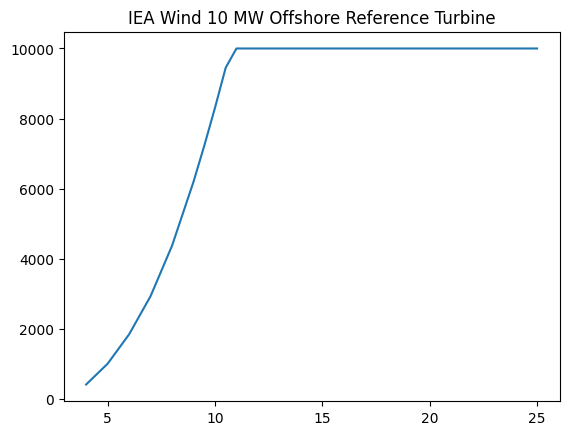

In [14]:
plt.plot(power_curve[:,0], power_curve[:,1])
plt.title(title);

In [15]:
# Set up the turbine for PyWake
from py_wake.wind_turbines import OneTypeWindTurbines

class IEA10MW(OneTypeWindTurbines):
    '''
    Data from:
    Christian Bak, Frederik Zahle, Robert Bitsche, Taeseong Kim, Anders Yde, Lars Christian Henriksen, Anand Natarajan,
    Morten Hartvig Hansen.“Description of the DTU 10 MW Reference Wind Turbine” DTU Wind Energy Report-I-0092, July 2013. Table 3.5

    '''

    def __init__(self):
        OneTypeWindTurbines.__init__(
            self,
            name=title,
            diameter=diameter,
            hub_height=hub_height,
            ct_func=self._ct,
            power_func=self._power,
            power_unit=power_unit)

    # converting into class data formats for Ct and P
    def _ct(self, u):
        return np.interp(u, ct_curve[:, 0], ct_curve[:, 1])

    def _power(self, u):
        return np.interp(u, power_curve[:, 0], power_curve[:, 1])


IEA10WM_RWT = IEA10MW()

## Set up models and calculate initial AEP and IRR

Now we will set up all the models we need for the optiimization problem and check their analysis

### Set up PyWake and AEP analysis

In [16]:
# set up turbines with initial positions
site.initial_position = np.array([[500968.1461, 5716452.78395],
                                        [499748.656451, 5717635.84752],
                                        [501245.774403, 5718427.21986],
                                        [500026.284754, 5719610.28343],
                                        [498527.828614, 5718809.39417],
                                        [497308.338965, 5719992.45774],
                                        [501523.402707, 5720401.65577],
                                        [500303.913058, 5721584.71934],
                                        [498805.456918, 5720783.83008],
                                        [497585.967269, 5721966.89364],
                                        [496087.511128, 5721166.00438],
                                        [494868.021479, 5722349.06795],
                                        [501801.03101, 5722376.09168],
                                        [500581.541361, 5723559.15524],
                                        [499083.085221, 5722758.26598],
                                        [497863.595572, 5723941.32955],
                                        [496365.139432, 5723140.44029],
                                        [495145.649783, 5724323.50386],
                                        [493647.193643, 5723522.6146],
                                        [492427.703994, 5724705.67817],
                                        [502078.659313, 5724350.52758],
                                        [500859.169664, 5725533.59115],
                                        [499360.713524, 5724732.70189],
                                        [498141.223875, 5725915.76546],
                                        [496642.767735, 5725114.8762],
                                        [495423.278086, 5726297.93977],
                                        [493924.821946, 5725497.05051],
                                        [492705.332297, 5726680.11408],
                                        [491206.876157, 5725879.22482],
                                        [489987.386508, 5727062.28839],
                                        [502356.287617, 5726324.96349],
                                        [501136.797968, 5727508.02706],
                                        [499638.341828, 5726707.1378],
                                        [498418.852179, 5727890.20137],
                                        [496920.396038, 5727089.31211],
                                        [495700.90639, 5728272.37568],
                                        [494202.450249, 5727471.48642],
                                        [492982.9606, 5728654.54999],
                                        [491484.50446, 5727853.66073],
                                        [490265.014811, 5729036.7243],
                                        [488766.558671, 5728235.83504],
                                        [487547.069022, 5729418.8986],
                                        [502633.91592, 5728299.3994],
                                        [501414.426271, 5729482.46297],
                                        [499915.970131, 5728681.57371],
                                        [498696.480482, 5729864.63728],
                                        [497198.024342, 5729063.74802],
                                        [495978.534693, 5730246.81159],
                                        [494480.078553, 5729445.92233],
                                        [493260.588904, 5730628.9859],
                                        [491762.132764, 5729828.09664],
                                        [490542.643115, 5731011.1602],
                                        [489044.186974, 5730210.27094],
                                        [487824.697325, 5731393.33451],
                                        [486326.241185, 5730592.44525],
                                        [485106.751536, 5731775.50882],
                                        [497475.652645, 5731038.18393],
                                        [496256.162996, 5732221.2475],
                                        [494757.706856, 5731420.35824],
                                        [493538.217207, 5732603.4218],
                                        [492039.761067, 5731802.53254],
                                        [490820.271418, 5732985.59611],
                                        [489321.815278, 5732184.70685],
                                        [488102.325629, 5733367.77042],
                                        [486603.869489, 5732566.88116],
                                        [497753.280949, 5733012.61984],
                                        [496533.7913, 5734195.6834],
                                        [495035.335159, 5733394.79414],
                                        [493815.845511, 5734577.85771],
                                        [492317.38937, 5733776.96845],
                                        [489599.443581, 5734159.14276],
                                        [498030.909252, 5734987.05574],
                                        [496811.419603, 5736170.11931],
                                        [495312.963463, 5735369.23005]])

# Assign initial x,y coordinates to be used later
x = site.initial_position[:,0]
y = site.initial_position[:,1]

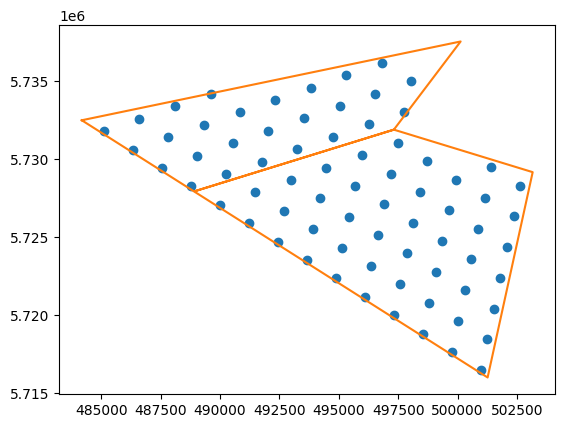

In [17]:
# visualize the site with the turbines in their initial positions
plt.plot(site.initial_position[:,0], site.initial_position[:,1], 'o')
ind = list(range(len(site.boundary))) + [0]
pt = plt.plot(site.boundary[ind,0], site.boundary[ind,1], '-')

In [18]:
# Set up the wind farm model with our layout, resource and turbine settings
#from py_wake import IEA37SimpleBastankhahGaussian
from py_wake import BastankhahGaussian
from py_wake.site import Site
from py_wake.wind_turbines import WindTurbines

wf_model = BastankhahGaussian(site, IEA10WM_RWT)

/usr/local/lib/python3.10/dist-packages/py_wake/deficit_models/gaussian.py:124: UserWarning: The BastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.gaussian_models.Bastankhah_PorteAgel_2014')


In [19]:
# run wind farm simulation
sim_aep = wf_model(x, y, yaw=0,# wind turbine positions
                   h=None, # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0, # Wind turbine types
                   wd=None, # Wind direction (defaults to site.default_wd (0,1,...,360 if not overriden))
                   ws=None, # Wind speed (defaults to site.default_ws (3,4,...,25m/s if not overriden))
                  )

In [20]:
# output of AEP
print('AEP:', sim_aep.aep().sum())

# output capacity factor
print('Capacity factor:', sim_aep.aep().sum()/(8760.*74*rated_power/1000000.))

# output wake losses
aep_with_wake_loss = sim_aep.aep().sum().data
aep_without_wake_loss = sim_aep.aep(with_wake_loss=False).sum().data
print('Wake losses %:',100*(aep_without_wake_loss-aep_with_wake_loss) / aep_without_wake_loss)

AEP: <xarray.DataArray 'AEP [GWh]' ()>
array(3586.11808751)
Capacity factor: <xarray.DataArray 'AEP [GWh]' ()>
array(0.55320839)
Wake losses %: 4.824473658973686


In [21]:
# Visualize the results
# flow_map = sim_aep.flow_map(grid=None, # defaults to HorizontalGrid(resolution=500, extend=0.2), see below
#                             wd=270,
#                             ws=None)

# flow_map.plot_wake_map()

In [22]:
# flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
#                        cmap='jet', # color map
#                        plot_colorbar=False,
#                        plot_windturbines=False,
#                        ax=None)
# plt.axis('equal')

In [23]:
# set up the aep function
def aep_func(x, y, **kwargs):

    return wf_model(x, y, yaw=0,# wind turbine positions
                   h=None, # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0, # Wind turbine types
                   wd=None, # Wind direction (defaults to site.default_wd (0,1,...,360 if not overriden))
                   ws=None, # Wind speed (defaults to site.default_ws (3,4,...,25m/s if not overriden))
                  ).aep().sum('ws').sum('wd').values * 10e6 # sums for each turbine and converts to kWh

# check function
aep_func(site.initial_position[:,0], site.initial_position[:,1])

array([5.01200647e+08, 4.95810939e+08, 4.92397690e+08, 4.86182821e+08,
       4.93832778e+08, 4.92373682e+08, 4.89323663e+08, 4.82735313e+08,
       4.83815478e+08, 4.82244006e+08, 4.91700887e+08, 4.91260068e+08,
       4.87608875e+08, 4.80985231e+08, 4.80317143e+08, 4.78768220e+08,
       4.81507360e+08, 4.81109991e+08, 4.91131772e+08, 4.91079933e+08,
       4.87080223e+08, 4.80685982e+08, 4.78577217e+08, 4.77196491e+08,
       4.78070990e+08, 4.77756359e+08, 4.80995584e+08, 4.81035527e+08,
       4.91141593e+08, 4.91302852e+08, 4.87548312e+08, 4.82054790e+08,
       4.78488982e+08, 4.77304717e+08, 4.76690092e+08, 4.76383333e+08,
       4.77708287e+08, 4.77931108e+08, 4.81249418e+08, 4.81782370e+08,
       4.91760903e+08, 4.92660475e+08, 4.90308512e+08, 4.88356703e+08,
       4.80809365e+08, 4.80671304e+08, 4.76984441e+08, 4.77079045e+08,
       4.76632954e+08, 4.77546446e+08, 4.78555946e+08, 4.79910835e+08,
       4.83072567e+08, 4.85647626e+08, 4.94530770e+08, 4.99818681e+08,
      

## Set up cost and electrical models

Now we will set up the cost models and electrical models for calculating IRR

In [24]:
# first import the cable and cost models (using the newer DTU cost model)
from topfarm.cost_models.electrical.simple_msp import ElNetLength, ElNetCost, XYCablePlotComp
from topfarm.cost_models.utils.spanning_tree import mst
from topfarm.cost_models.economic_models.dtu_wind_cm_main import economic_evaluation as EE_DTU

# additional site input parameters
n_wt = 74 # number of wind turbines
distance_from_shore = 45.0 # [km]
energy_price = 0.2 / 7.4 # [DKK/kWh] / [DKK/EUR] -> [EUR/kWh]
project_duration = 20 # [years]
water_depth_array = 30. * np.ones([n_wt])
Power_rated_array = np.ones([n_wt])*rated_power/1.0E3 # [MW]

# additional inputs for collection system
cable_cost_per_meter = 750. #@param {type:"slider", min:0, max:10000, step:1}


In [25]:
# now set up the cost function for use in the optimization
def irr_dtu(aep, electrical_connection_cost, **kwargs):
    ee_dtu = EE_DTU(distance_from_shore, energy_price, project_duration)
    rated_rpm_array = np.ones([n_wt])*12.
    Drotor_vector = np.ones([n_wt]) * diameter
    power_rated_vector = np.ones([n_wt]) * rated_power / 1000. # kW to MW
    hub_height_vector = np.ones([n_wt]) * hub_height
    ee_dtu.calculate_irr(
                    rated_rpm_array,
                    Drotor_vector,
                    Power_rated_array,
                    hub_height_vector,
                    water_depth_array,
                    aep,
                    electrical_connection_cost)
    return ee_dtu.IRR

# check function operation
my_aep = np.ones([n_wt])*3616.39782621/74.
electrical_cost = 0.0
print(irr_dtu(my_aep,electrical_cost))

nan


## Set up optimization problem and execute

Now finally that we have our inputs set up, our analysis functions configured, lets set up the formal TOPFARM problem

In [26]:
# Import topfarm optimization classes and helper functions
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm import TopFarmGroup, TopFarmProblem
from topfarm.easy_drivers import EasyRandomSearchDriver, EasyScipyOptimizeDriver, EasySimpleGADriver
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle, RandomizeTurbinePosition
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint

<ipython-input-27-df4f37471cac>:10: DeprecationWarning: output_key is deprecated; use keyword output_keys instead
  irr_dtu_comp = CostModelComponent(input_keys=[('aep',np.zeros(n_wt)), ('electrical_connection_cost', 0.0)],   n_wt=n_wt,
<ipython-input-27-df4f37471cac>:15: DeprecationWarning: output_key is deprecated; use keyword output_keys instead
  aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func,
<ipython-input-27-df4f37471cac>:15: DeprecationWarning: output_val is deprecated; use keyword output_vals instead
  aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func,


''

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


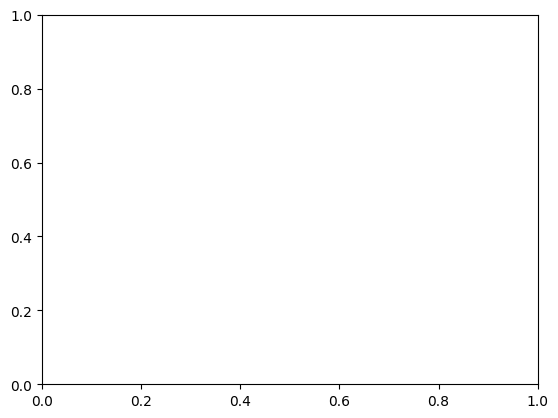

In [27]:
# Minimum spacing between the turbines
min_spacing = 3 # #rotor diameters

## Electrical grid cable components (Minimum spanning tree from Topfarm report 2010)
# Note that the electrical model is already set up in OpenMDAO (sub-coptimization)
elnetlength = ElNetLength(n_wt=n_wt)
elnetcost = ElNetCost(n_wt=n_wt, output_key='electrical_connection_cost', cost_per_meter=cable_cost_per_meter)

# The Topfarm IRR cost model components
irr_dtu_comp = CostModelComponent(input_keys=[('aep',np.zeros(n_wt)), ('electrical_connection_cost', 0.0)],   n_wt=n_wt,
                                  cost_function=irr_dtu, output_key="irr", output_unit="%",   objective=True,
                                  maximize=True)

# The Topfarm AEP component, returns an array of AEP per turbine
aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func,
                              output_key="aep", output_unit="kWh", objective=False, output_val=np.zeros(n_wt))

# Plotting component
plot_comp = XYCablePlotComp(memory=0, plot_improvements_only=False, plot_initial=False)


# The group containing all the components
group = TopFarmGroup([aep_comp, elnetlength, elnetcost, irr_dtu_comp])

problem = TopFarmProblem(
        design_vars={'x':(site.initial_position[:,0], site.boundary[:,0].min(), site.boundary[:,0].max()),
                     'y':(site.initial_position[:,1], site.boundary[:,1].min(), site.boundary[:,1].max())},
        cost_comp=group,
        driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition(max_step=100), max_iter=100),
        # driver=EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=200, tol=1e-6, disp=False),
        constraints=[SpacingConstraint(min_spacing * diameter),
                     XYBoundaryConstraint(site.boundary)],
        expected_cost=0.01,
        plot_comp=plot_comp)

# check model runs
# problem.run_model()

INFO: checking out_of_order


INFO:check_config:checking out_of_order


INFO: checking system


INFO:check_config:checking system


INFO: checking solvers


INFO:check_config:checking solvers


INFO: checking dup_inputs


INFO:check_config:checking dup_inputs


INFO: checking missing_recorders


INFO:check_config:checking missing_recorders


INFO: checking unserializable_options


INFO:check_config:checking unserializable_options


INFO: checking comp_has_no_outputs


INFO:check_config:checking comp_has_no_outputs


INFO: checking auto_ivc_warnings


INFO:check_config:checking auto_ivc_warnings


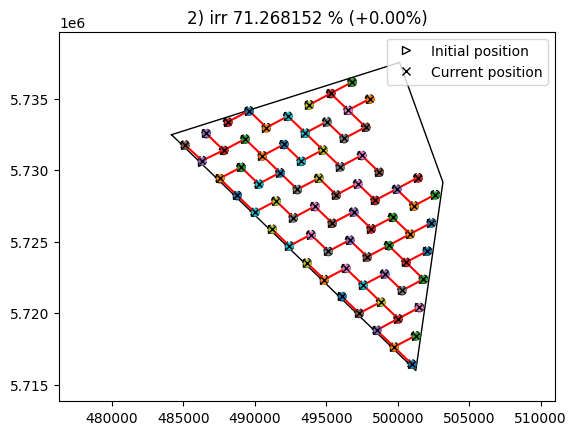

In [ ]:
# Finally run the optimization
cost, state, recorder = problem.optimize()

In [ ]:
# print the final results of the turbine positions
print(cost)

In [ ]:
plt.plot(recorder['aep'].sum(1))
plt.title('aep [kWh]')

In [ ]:
# plot for irr_dtu_comp
plt.plot(recorder['irr'])
plt.title('irr')

For this optimization, we note that the main drivers of the optimization are the trade-off of cable costs and AEP (by design). The other elements of the cost and financial model are not sensitivity to this. Sometimes then, it is nice to simplify the objective function to better see these trade-offs.

Below, we introduce a new cost model that is the cost of electrical connection weighted by its percent of CAPEX over AEP. This could be modified to weight it from an LCOE perspective, or any other weighting that the user defines.

In [ ]:
# alternative simplified cost model to explicitly acount for cost and aep only (a LCOE proxy)
def my_cost(aep, electrical_connection_cost, **kwargs):

    return ((electrical_connection_cost/0.14)/(aep.sum()))

my_cost_comp = CostModelComponent(input_keys=[('aep',np.zeros(n_wt)), ('electrical_connection_cost', 0.0)],   n_wt=n_wt,
                                  cost_function=my_cost, output_key="lcoe", output_unit="%",   objective=True,
                                  maximize=False)

# Minimum spacing between the turbines
min_spacing = 3 # #rotor diameters

## Electrical grid cable components (Minimum spanning tree from Topfarm report 2010)
# Note that the electrical model is already set up in OpenMDAO (sub-coptimization)
elnetlength = ElNetLength(n_wt=n_wt)
elnetcost = ElNetCost(n_wt=n_wt, output_key='electrical_connection_cost', cost_per_meter=cable_cost_per_meter)

# The Topfarm AEP component, returns an array of AEP per turbine
aep_comp = CostModelComponent(input_keys=['x','y'], n_wt=n_wt, cost_function=aep_func,
                              output_key="aep", output_unit="kWh", objective=False, output_val=np.zeros(n_wt))

# Plotting component
plot_comp = XYCablePlotComp(memory=0, plot_improvements_only=False, plot_initial=False)

# The group containing all the components
group = TopFarmGroup([aep_comp, elnetlength, elnetcost, my_cost_comp])

problem = TopFarmProblem(
        design_vars={'x':site.initial_position[:,0],
                     'y':site.initial_position[:,1]},
        cost_comp=group,
#         driver=EasyRandomSearchDriver(randomize_func=RandomizeTurbinePosition_Circle(), max_iter=10),
        driver=EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=20, tol=1e-6, disp=False),
        constraints=[SpacingConstraint(min_spacing * diameter),
                     XYBoundaryConstraint(site.boundary)],
        expected_cost=0.01,
        plot_comp=plot_comp)

# check model runs
# problem.run_model()

In [ ]:
# Run optimization with new cost model
cost, state, recorder = problem.optimize()

In [ ]:
# print the final results of the turbine positions
print(cost)

In [ ]:
# plot aep
plt.plot(recorder['aep'].sum(1))
plt.title('aep [kWh]')

In [ ]:
# plot for my_cost_comp
plt.plot(recorder['lcoe'])
plt.title('lcoe')